In [5]:
# # to load in script (from server): >>> execfile('/home/gm441/python_scripts/DMS_climatologies/run_dms_interp_k11.py')
# # to load in script (from local):  >>> execfile('/Users/gm441/GD/phd/resources/coding/py_repos/dms_climatologies/run_dms_interp_k11.py')

#%%
# # IMPORT MODULES # #

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate as interp
from scipy.stats import truncnorm
from scipy.stats import ttest_ind
import collections as c
import pwlf
import os
import numpy.polynomial.polynomial as poly

#scriptpath = '/Users/gm441/GD/phd/resources/coding/py_repos/observed_data/2020_processing_20-06-13/'
#outpath = '/Users/gm441/GD/phd/resources/coding/py_repos/observed_data/2020_processed/'


## Random sampled from normal distribution
mean=5.5, sd=2.0, low=1.0, upp=70.0

In [31]:

#%%
#values = [10,50,100,300,3000]                                                  # # number of data points (tnum)
values = [300]                                                                  # # number of data points (tnum)
vlslog_list = []
r2log_list = []
tlog_list = []
plog_list = []

datadict = c.OrderedDict()

for value in values:
#    plt.figure()
#    fig = plt.figure()
    tnum = 't_'+str(value)
    datadict[tnum] = {}
    for j in range(10):                                                        # # number of loop repeats (rnum)
        rnum = 'r_'+str(j)
        datadict[tnum][rnum] = {}
# # # ------------------------------------------------------------------------------------------------------------
        # # RANDOM TEST # #
        
        def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
            return truncnorm(
                (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
        
        dms_range = get_truncated_normal(mean=5.5, sd=2.0, low=1.0, upp=70.0)
        rand_dms = dms_range.rvs(value)

#        spatial_res = np.ndarray(value,dtype=float)
#        spatial_res[:] = 1000
        dist_range = get_truncated_normal(mean=1000.0, sd=2.0, low=200.0, upp=3000.0)
        rand_dist = dist_range.rvs(value)
        
        data = pd.DataFrame(np.array([rand_dms,rand_dist]).T, columns = ['DMSsw','distance'])
#        data = pd.DataFrame(np.array([rand_dms,spatial_res]).T, columns = ['DMSsw','distance'])
                
# # # ------------------------------------------------------------------------------------------------------------
        # # SET INPUT PARAMETERS & NO. OF BINS # #
        
        DMS = data['DMSsw'].to_numpy()                                                  # # select DMS data column
        dist = (data['distance']/1000.0).to_numpy()                                     # # convert distance between measurements to km
        kmCov = np.cumsum(dist)                                                         # # cumulative transect distance
        maxlen = int(np.max(kmCov))                                                     # # max transect length as an integer
        maxbins = int(maxlen/2.2)                                                         # # required for later calcs. MSE=0 where bin number > (transect length)/2
#        halflen = int(maxlen/2)                                                         # # required for later calcs. MSE=0 where bin number > (transect length)/2
#        interpint = np.arange(1,halflen+2,1,dtype=np.int)                               # # set range & intervals as: 1km to halflen +2, stepping every 1km. (+1 to create 1 extra bin (because losing bin_0) and +1 to include the max value as the end point = +2)
        interpint = np.arange(1,maxbins+1,1,dtype=np.int)                               # # set range & intervals as: 1km to halflen +2, stepping every 1km. (+1 to create 1 extra bin (because losing bin_0) and +1 to include the max value as the end point = +2)

# # # ------------------------------------------------------------------------------------------------------------
        # # BIN, INTERPOLATE & MSE # # 
        
        processed = c.OrderedDict()
        processed['bin_sizes'] = float(maxlen)/interpint 
                                       # # no.of values to be averaged into bin
        for i in np.arange(len(interpint))+1:                                           # # for each bin size ( 1 : max km (rounded), every 1 ) (Can't start at bin_0 as 'bins' should be a positive integer, i.e. from bin_1 onward)
#            print i
            bin_number = 'bin_'+str(i)                                                  # # set bin_number as bin_ + i
            bin_dms = []                                                                # # empty temporary array
            bin_dist = []                                                               # # empty temporary array
            tempbin = np.array(pd.cut(data.index, i,labels=range(i)))                   # # temporary array for bin steps based on i in data.index
            for i in np.unique(tempbin):                                                # # for i in bin column values i.e. in bin_44, i = 0-43. Set to unique, to remove repetition of values which fill transect length (0,0,0,1,1,1,2,2,2,3,3,3,4,4,4...43,43,43 etc.)
                bin_dms.append(np.nanmean(DMS[np.where(tempbin == i)].astype('float')))       # # append average DMS values for bin
                bin_dist.append(np.nanmean(kmCov[np.where(tempbin == i)].astype('float')))    # # append average distances for bin
            processed[bin_number] = {}
            processed[bin_number]['dms_mean'] = bin_dms                                 # # bin average DMS
            processed[bin_number]['avdist'] = bin_dist                                  # # bin average distance
        
        print("Transect length:", maxlen, "km")
        print("No. interpolation intervals (BINS):", len(interpint))
        
        MSE = []
        
        for i in np.arange(len(interpint)-1)+2:                                         # # loop through bins 2-end inclusive. Start at bin_2, as can't interpolate the single value in bin_1
            # # INTERPOLATION # #
            x = np.array(processed['bin_'+str(i)]['avdist'])
            y = np.array(processed['bin_'+str(i)]['dms_mean'])                          # # DMS values averaged into bins
            interp_rows = np.where((kmCov > np.nanmin(x)) & (kmCov < np.nanmax(x)))[0]
            f = interp.interp1d(x,y)                                                    # # new function interpolate x & y
            DISTinterp = kmCov[interp_rows]
            DMSinterp = f(DISTinterp)                                                   # # use interpolation function returned by 'interp1d'
            # # MEAN SQUARED ERROR # #
            mse = np.nanmean((DMS[interp_rows] - DMSinterp)**2)                                      # # (dms original - dms intp) squared, then averaged to get one value per bin.
            MSE.append(mse)                                                             # # append to list for all bins
#            print 'Bin_',str(i), 'MSE', mse

#        plt.figure()
#        plt.scatter(kmCov,DMS, color = 'g', label = 'Observed', alpha = 0.5)
#        plt.scatter(DISTinterp,DMSinterp, label = bin_number + 'Interpolated', alpha = 0.5)
#        plt.xlabel('Distance (km)')
#        plt.ylabel('DMS (nM)')
#        plt.grid(b=None, which='major', axis='both')
#        plt.legend()
#        plt.show(block=False)
        
# # # ------------------------------------------------------------------------------------------------------------
        # # PIECEWISE LINEAR REGRESSION - LINEAR # #
        
        d = processed['bin_sizes'][1:]                                                  # # bin_sizes (minus the last value, as bin_1 not included)
        e = np.array(MSE[:])                                                                         # # mse values for bin_2 to bin_max
        space_lin = np.linspace(d.min(), d.max(), 1000)                                 # # new temp variable for an arbritrary 1000 points, linearly spaced between bin SIZES bin_2 and bin_max         
        my_pwlf = pwlf.PiecewiseLinFit(d, e)                                            # # use pwlf function PiecewiseLinFit
        
        # # FOR TRUNCATED VLS # #
        #u = d[0:507]                                           # # 197 for 20 km, 297 for 30 km, 397 for 40 km, 497 for 50 km, 997 for 100 km (507 for 51km)
        #v = e[0:507]
        #space_lin = np.linspace(u.min(), u.max(), 1000)                                # # for trunctated VLS
        #my_pwlf = pwlf.PiecewiseLinFit(u, v)                                           # # use pwlf function PiecewiseLinFit
        
        vls = my_pwlf.fit(2)                                                            # # find fit with prescribed no. of segments (x) (no. segments = no. inflections +1)
        pwlr = my_pwlf.predict(space_lin)                                               # # predicted PWLR
        
        print('linear VLS = ', vls[1])
        
        # # Get the slopes
        slopes = my_pwlf.calc_slopes()                                                  # # slope gradients of the two segmented linear regressions
        # # Get my model parameters
        Beta = my_pwlf.beta                                                             # # 3 beta values for the regressions
        # # Calculate the standard errors associated with each beta parameter
        se = my_pwlf.standard_errors()                                                  # # standard error for each beta parameter
        # # Calculate the R^2 value
        rsq = my_pwlf.r_squared()                                                       # # r squared value for the full regression
        
        # calculate the piecewise R^2 value
        R2values = np.zeros(my_pwlf.n_segments)
        for i in range(my_pwlf.n_segments):
            # segregate the data based on break point locations
            xmin = my_pwlf.fit_breaks[i]
            xmax = my_pwlf.fit_breaks[i+1]
            xtemp = my_pwlf.x_data
            ytemp = my_pwlf.y_data
            indtemp = np.where(xtemp >= xmin)
            xtemp = my_pwlf.x_data[indtemp]
            ytemp = my_pwlf.y_data[indtemp]
            indtemp = np.where(xtemp <= xmax)
            xtemp = xtemp[indtemp]
            ytemp = ytemp[indtemp]
        
            # predict for the new data
            yhattemp = my_pwlf.predict(xtemp)
        
            # calculate ssr
            E = yhattemp - ytemp                                                        # # residual vector
            ssr = np.dot(E, E)                                                          # # sum-of-squares of the residuals
        
            # calculate sst
            ybar = np.ones(ytemp.size) * np.mean(ytemp)                                 # # ybar = mean of vector y
            ydiff = ytemp - ybar
            sst = np.dot(ydiff, ydiff)                                                  # # total sum-of-squares
        
            R2values[i] = 1.0 - (ssr/sst)                                               # # coefficient of determination (R2)
        
        print('Segment R-squared values = ', R2values)
        
        datadict[tnum][rnum]['bin_sizes'] = d
        datadict[tnum][rnum]['mse'] = e
        datadict[tnum][rnum]['space_lin'] = space_lin
        datadict[tnum][rnum]['pwlr'] = pwlr
        datadict[tnum][rnum]['vls'] = vls

# # # ------------------------------------------------------------------------------------------------------------
        # # Find y (MSE) intercept at inflection point in PWLR - LINEAR # #
        
#        def find_nearest(array, value):
#            array = np.asarray(array)
#            idx = (np.abs(array - value)).argmin()
#            return array[idx]
#        
#        # # For 1st of ... inflections
#        inflec1 = find_nearest(space_lin, vls[1])
#        inflec1_index = list(space_lin).index(inflec1)
#        mse_intcpt1 = pwlr[inflec1_index]
#        print mse_intcpt1
#        
#        # # For 2nd of ... inflections
#        if len(vls) > 3:
#            inflec2 = find_nearest(space_lin, vls[2])
#            inflec2_index = list(space_lin).index(inflec2)
#            mse_intcpt2 = pwlr[inflec2_index]
#            print mse_intcpt2
#        else:
#            print 'Only 1 inflection'
        
# # # ------------------------------------------------------------------------------------------------------------
        # # Test significance of difference between the slopes (t-test & p-value) - LINEAR # #
        
#        # # For ONE inflection # #
#        if len(vls) <= 3:
#            a = pwlr[0:inflec1_index]
#            b = pwlr[inflec1_index:]
#            
#            t, p = ttest_ind(a, b, equal_var=False)
#            print 'One Inflection'
#            print("ttest_ind:            t = %g  p = %g" % (t, p))
#            if p < 0.05:
#                print 'SIGNIFICANT'
#            else:
#                print 'NOT SIGNIFICANT'
        
            # # VLS LINEAR SPACING # #
            
        d1 = np.log(d)
        e1 = np.log(e)
        
        z1 = np.polyfit(d1, e1, 4)
        fp1 = np.poly1d(z1)
        
        xnew1 = np.linspace(d1.min(), d1.max(), 1000)
        ynew1 = fp1(xnew1)

        my_pwlf1 = pwlf.PiecewiseLinFit(d1, e1)
        vls1 = my_pwlf1.fit(2)                                                          
        pwlr1 = my_pwlf1.predict(xnew1)                                            
        vls_inv = np.exp(vls1)
        
        #---------------------------------------------

        coefs = poly.polyfit(d1, e1, 4)
        ffit = poly.polyval(xnew1, coefs)
        
        #---------------------------------------------
        
        pwrbase = -1.5
        
        d2 = np.power(d,pwrbase)
        e2 = np.power(e,pwrbase)

        z2 = np.polyfit(d2, e2, 1)
        fp2 = np.poly1d(z2)
        
        xnew2 = np.linspace(d2.min(), d2.max(), 1000)
        ynew2 = fp2(xnew2)

        my_pwlf2 = pwlf.PiecewiseLinFit(d2, e2)
        vls2 = my_pwlf2.fit(2)                                                          
        pwlr2 = my_pwlf2.predict(xnew2)                                            
        vls_pinv = np.power(vls2,(1.0/pwrbase))
        
        datadict[tnum][rnum]['bin_sizes_log'] = d1
        datadict[tnum][rnum]['mse_log'] = e1
        datadict[tnum][rnum]['space_log'] = xnew1
        datadict[tnum][rnum]['pwlr_log'] = pwlr1
        datadict[tnum][rnum]['vls_log'] = vls1
        datadict[tnum][rnum]['vls_inv'] = vls_inv

        datadict[tnum][rnum]['bin_sizes_pwr'] = d2
        datadict[tnum][rnum]['mse_pwr'] = e2
        datadict[tnum][rnum]['space_pwr'] = xnew2
        datadict[tnum][rnum]['linfit_pwr'] = ynew2
        datadict[tnum][rnum]['pwlr_pwr'] = pwlr2
        datadict[tnum][rnum]['vls_pwr'] = vls2
        datadict[tnum][rnum]['vls_pinv'] = vls_pinv
        



Transect length: 300 km
No. interpolation intervals (BINS): 136
linear VLS =  5.210152053290684
Segment R-squared values =  [0.89933442 0.08521966]
Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  6.406984506915044
Segment R-squared values =  [0.88484384 0.68781656]
Transect length: 300 km
No. interpolation intervals (BINS): 136
linear VLS =  5.128451033556277
Segment R-squared values =  [0.855827   0.27153658]
Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  7.575450332140257
Segment R-squared values =  [0.89952604 0.39790411]
Transect length: 300 km
No. interpolation intervals (BINS): 136
linear VLS =  7.440260572210269
Segment R-squared values =  [0.92881346 0.3576555 ]
Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  6.729212709672463
Segment R-squared values =  [0.88040509 0.62514388]
Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  7.39031261483193
Segment R-squared

<ipython-input-32-5754eef5a373>:30: RuntimeWarning: invalid value encountered in power
  ax3.set_xticklabels(np.power(xticks,(1.0/pwrbase)).round(4))


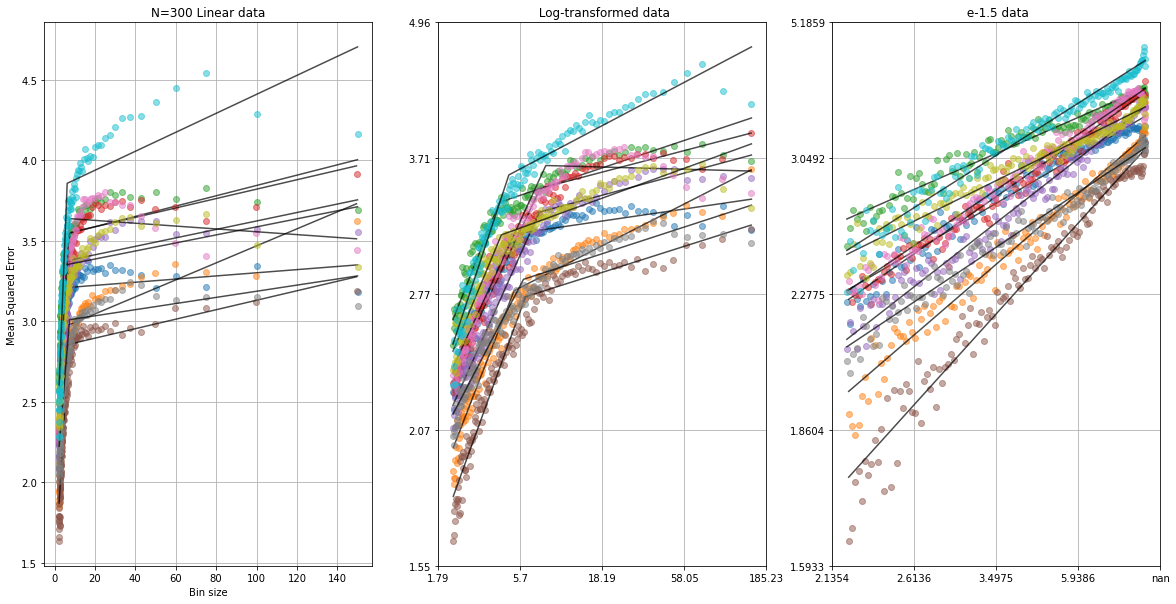

In [32]:

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,10))

for rnum in list(datadict[tnum]):

    ax1.plot(datadict[tnum][rnum]['bin_sizes'], datadict[tnum][rnum]['mse'], 'o', alpha=0.5)
    ax1.plot(datadict[tnum][rnum]['space_lin'], datadict[tnum][rnum]['pwlr'], '-', color='k', alpha=0.7)
    
    ax2.plot(datadict[tnum][rnum]['bin_sizes_log'], datadict[tnum][rnum]['mse_log'], 'o', alpha=0.5)
    ax2.plot(datadict[tnum][rnum]['space_log'], datadict[tnum][rnum]['pwlr_log'], '-', color='k', alpha=0.7)
    
#     ax3.plot(np.flip(datadict[tnum][rnum]['bin_sizes_pwr']), np.flip(datadict[tnum][rnum]['mse_pwr']), 'o', alpha=0.5)
#     ax3.plot(np.flip(datadict[tnum][rnum]['space_pwr']), np.flip(datadict[tnum][rnum]['linfit_pwr']), '-', color='k', alpha=0.7)
    ax3.plot((datadict[tnum][rnum]['bin_sizes_pwr']),(datadict[tnum][rnum]['mse_pwr']), 'o', alpha=0.5)
    ax3.plot((datadict[tnum][rnum]['space_pwr']),(datadict[tnum][rnum]['linfit_pwr']), '-', color='k', alpha=0.7)

xmin, xmax = ax2.get_xlim()
xticks = np.linspace(xmin,xmax,5)
ax2.set_xticks(xticks)
ax2.set_xticklabels(np.exp(xticks).round(2))

ymin, ymax = ax2.get_ylim()
yticks = np.linspace(ymin,ymax,5)
ax2.set_yticks(yticks)
ax2.set_yticklabels(np.exp(yticks).round(2)) 

xmin, xmax = ax3.get_xlim()
ax3.set_xlim([xmax,xmin])
xticks = np.linspace(xmin,xmax,5)
ax3.set_xticks(xticks)
ax3.set_xticklabels(np.power(xticks,(1.0/pwrbase)).round(4))

ymin, ymax = ax3.get_ylim()
ax3.set_ylim([ymax,ymin])
yticks = np.linspace(ymin,ymax,5)
ax3.set_yticks(yticks)
ax3.set_yticklabels(np.power(yticks,(1.0/pwrbase)).round(4))

ax1.set_xlabel('Bin size')
ax1.set_ylabel('Mean Squared Error')
    
ax1.set_title('N=' + str(len(dist)) + ' Linear data')
ax2.set_title(' Log-transformed data')
ax3.set_title(' e-1.5 data')
ax1.grid(b=None, which='both', axis='both')
ax2.grid(b=None, which='both', axis='both')
ax3.grid(b=None, which='both', axis='both')
plt.show()

#

## totally random data

In [41]:

#%%
#values = [10,50,100,300,3000]                                                  # # number of data points (tnum)
values = [300]                                                                  # # number of data points (tnum)
vlslog_list = []
r2log_list = []
tlog_list = []
plog_list = []

datadict = c.OrderedDict()

for value in values:
#    plt.figure()
#    fig = plt.figure()
    tnum = 't_'+str(value)
    datadict[tnum] = {}
    for j in range(10):                                                        # # number of loop repeats (rnum)
        rnum = 'r_'+str(j)
        datadict[tnum][rnum] = {}
# # # ------------------------------------------------------------------------------------------------------------
        # # RANDOM TEST # #
        
        def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
            return truncnorm(
                (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
        
        dms_range = get_truncated_normal(mean=0.75, sd=2.0, low=1.0, upp=70.0)
        rand_dms = dms_range.rvs(value)

#        spatial_res = np.ndarray(value,dtype=float)
#        spatial_res[:] = 1000
        dist_range = get_truncated_normal(mean=1000.0, sd=2.0, low=200.0, upp=3000.0)
        rand_dist = dist_range.rvs(value)
        
        data = pd.DataFrame(np.array([rand_dms,rand_dist]).T, columns = ['DMSsw','distance'])
#        data = pd.DataFrame(np.array([rand_dms,spatial_res]).T, columns = ['DMSsw','distance'])
                
# # # ------------------------------------------------------------------------------------------------------------
        # # SET INPUT PARAMETERS & NO. OF BINS # #
        
        DMS = data['DMSsw'].to_numpy()                                                  # # select DMS data column
        dist = (data['distance']/1000.0).to_numpy()                                     # # convert distance between measurements to km
        kmCov = np.cumsum(dist)                                                         # # cumulative transect distance
        maxlen = int(np.max(kmCov))                                                     # # max transect length as an integer
        maxbins = int(maxlen/2.2)                                                         # # required for later calcs. MSE=0 where bin number > (transect length)/2
#        halflen = int(maxlen/2)                                                         # # required for later calcs. MSE=0 where bin number > (transect length)/2
#        interpint = np.arange(1,halflen+2,1,dtype=np.int)                               # # set range & intervals as: 1km to halflen +2, stepping every 1km. (+1 to create 1 extra bin (because losing bin_0) and +1 to include the max value as the end point = +2)
        interpint = np.arange(1,maxbins+1,1,dtype=np.int)                               # # set range & intervals as: 1km to halflen +2, stepping every 1km. (+1 to create 1 extra bin (because losing bin_0) and +1 to include the max value as the end point = +2)

# # # ------------------------------------------------------------------------------------------------------------
        # # BIN, INTERPOLATE & MSE # # 
        
        processed = c.OrderedDict()
        processed['bin_sizes'] = float(maxlen)/interpint 
                                       # # no.of values to be averaged into bin
        for i in np.arange(len(interpint))+1:                                           # # for each bin size ( 1 : max km (rounded), every 1 ) (Can't start at bin_0 as 'bins' should be a positive integer, i.e. from bin_1 onward)
#            print i
            bin_number = 'bin_'+str(i)                                                  # # set bin_number as bin_ + i
            bin_dms = []                                                                # # empty temporary array
            bin_dist = []                                                               # # empty temporary array
            tempbin = np.array(pd.cut(data.index, i,labels=range(i)))                   # # temporary array for bin steps based on i in data.index
            for i in np.unique(tempbin):                                                # # for i in bin column values i.e. in bin_44, i = 0-43. Set to unique, to remove repetition of values which fill transect length (0,0,0,1,1,1,2,2,2,3,3,3,4,4,4...43,43,43 etc.)
                bin_dms.append(np.nanmean(DMS[np.where(tempbin == i)].astype('float')))       # # append average DMS values for bin
                bin_dist.append(np.nanmean(kmCov[np.where(tempbin == i)].astype('float')))    # # append average distances for bin
            processed[bin_number] = {}
            processed[bin_number]['dms_mean'] = bin_dms                                 # # bin average DMS
            processed[bin_number]['avdist'] = bin_dist                                  # # bin average distance
        
        print("Transect length:", maxlen, "km")
        print("No. interpolation intervals (BINS):", len(interpint))
        
        MSE = []
        
        for i in np.arange(len(interpint)-1)+2:                                         # # loop through bins 2-end inclusive. Start at bin_2, as can't interpolate the single value in bin_1
            # # INTERPOLATION # #
            x = np.array(processed['bin_'+str(i)]['avdist'])
            y = np.array(processed['bin_'+str(i)]['dms_mean'])                          # # DMS values averaged into bins
            interp_rows = np.where((kmCov > np.nanmin(x)) & (kmCov < np.nanmax(x)))[0]
            f = interp.interp1d(x,y)                                                    # # new function interpolate x & y
            DISTinterp = kmCov[interp_rows]
            DMSinterp = f(DISTinterp)                                                   # # use interpolation function returned by 'interp1d'
            # # MEAN SQUARED ERROR # #
            mse = np.nanmean((DMS[interp_rows] - DMSinterp)**2)                                      # # (dms original - dms intp) squared, then averaged to get one value per bin.
            MSE.append(mse)                                                             # # append to list for all bins
#            print 'Bin_',str(i), 'MSE', mse

#        plt.figure()
#        plt.scatter(kmCov,DMS, color = 'g', label = 'Observed', alpha = 0.5)
#        plt.scatter(DISTinterp,DMSinterp, label = bin_number + 'Interpolated', alpha = 0.5)
#        plt.xlabel('Distance (km)')
#        plt.ylabel('DMS (nM)')
#        plt.grid(b=None, which='major', axis='both')
#        plt.legend()
#        plt.show(block=False)
        
# # # ------------------------------------------------------------------------------------------------------------
        # # PIECEWISE LINEAR REGRESSION - LINEAR # #
        
        d = processed['bin_sizes'][1:]                                                  # # bin_sizes (minus the last value, as bin_1 not included)
        e = np.array(MSE[:])                                                                         # # mse values for bin_2 to bin_max
        space_lin = np.linspace(d.min(), d.max(), 1000)                                 # # new temp variable for an arbritrary 1000 points, linearly spaced between bin SIZES bin_2 and bin_max         
        my_pwlf = pwlf.PiecewiseLinFit(d, e)                                            # # use pwlf function PiecewiseLinFit
        
        # # FOR TRUNCATED VLS # #
        #u = d[0:507]                                           # # 197 for 20 km, 297 for 30 km, 397 for 40 km, 497 for 50 km, 997 for 100 km (507 for 51km)
        #v = e[0:507]
        #space_lin = np.linspace(u.min(), u.max(), 1000)                                # # for trunctated VLS
        #my_pwlf = pwlf.PiecewiseLinFit(u, v)                                           # # use pwlf function PiecewiseLinFit
        
        vls = my_pwlf.fit(2)                                                            # # find fit with prescribed no. of segments (x) (no. segments = no. inflections +1)
        pwlr = my_pwlf.predict(space_lin)                                               # # predicted PWLR
        
        print('linear VLS = ', vls[1])
        
        # # Get the slopes
        slopes = my_pwlf.calc_slopes()                                                  # # slope gradients of the two segmented linear regressions
        # # Get my model parameters
        Beta = my_pwlf.beta                                                             # # 3 beta values for the regressions
        # # Calculate the standard errors associated with each beta parameter
        se = my_pwlf.standard_errors()                                                  # # standard error for each beta parameter
        # # Calculate the R^2 value
        rsq = my_pwlf.r_squared()                                                       # # r squared value for the full regression
        
        # calculate the piecewise R^2 value
        R2values = np.zeros(my_pwlf.n_segments)
        for i in range(my_pwlf.n_segments):
            # segregate the data based on break point locations
            xmin = my_pwlf.fit_breaks[i]
            xmax = my_pwlf.fit_breaks[i+1]
            xtemp = my_pwlf.x_data
            ytemp = my_pwlf.y_data
            indtemp = np.where(xtemp >= xmin)
            xtemp = my_pwlf.x_data[indtemp]
            ytemp = my_pwlf.y_data[indtemp]
            indtemp = np.where(xtemp <= xmax)
            xtemp = xtemp[indtemp]
            ytemp = ytemp[indtemp]
        
            # predict for the new data
            yhattemp = my_pwlf.predict(xtemp)
        
            # calculate ssr
            E = yhattemp - ytemp                                                        # # residual vector
            ssr = np.dot(E, E)                                                          # # sum-of-squares of the residuals
        
            # calculate sst
            ybar = np.ones(ytemp.size) * np.mean(ytemp)                                 # # ybar = mean of vector y
            ydiff = ytemp - ybar
            sst = np.dot(ydiff, ydiff)                                                  # # total sum-of-squares
        
            R2values[i] = 1.0 - (ssr/sst)                                               # # coefficient of determination (R2)
        
        print('Segment R-squared values = ', R2values)
        
        datadict[tnum][rnum]['bin_sizes'] = d
        datadict[tnum][rnum]['mse'] = e
        datadict[tnum][rnum]['space_lin'] = space_lin
        datadict[tnum][rnum]['pwlr'] = pwlr
        datadict[tnum][rnum]['vls'] = vls

# # # ------------------------------------------------------------------------------------------------------------
        # # Find y (MSE) intercept at inflection point in PWLR - LINEAR # #
        
#        def find_nearest(array, value):
#            array = np.asarray(array)
#            idx = (np.abs(array - value)).argmin()
#            return array[idx]
#        
#        # # For 1st of ... inflections
#        inflec1 = find_nearest(space_lin, vls[1])
#        inflec1_index = list(space_lin).index(inflec1)
#        mse_intcpt1 = pwlr[inflec1_index]
#        print mse_intcpt1
#        
#        # # For 2nd of ... inflections
#        if len(vls) > 3:
#            inflec2 = find_nearest(space_lin, vls[2])
#            inflec2_index = list(space_lin).index(inflec2)
#            mse_intcpt2 = pwlr[inflec2_index]
#            print mse_intcpt2
#        else:
#            print 'Only 1 inflection'
        
# # # ------------------------------------------------------------------------------------------------------------
        # # Test significance of difference between the slopes (t-test & p-value) - LINEAR # #
        
#        # # For ONE inflection # #
#        if len(vls) <= 3:
#            a = pwlr[0:inflec1_index]
#            b = pwlr[inflec1_index:]
#            
#            t, p = ttest_ind(a, b, equal_var=False)
#            print 'One Inflection'
#            print("ttest_ind:            t = %g  p = %g" % (t, p))
#            if p < 0.05:
#                print 'SIGNIFICANT'
#            else:
#                print 'NOT SIGNIFICANT'
        
            # # VLS LINEAR SPACING # #
            
        d1 = np.log(d)
        e1 = np.log(e)
        
        z1 = np.polyfit(d1, e1, 4)
        fp1 = np.poly1d(z1)
        
        xnew1 = np.linspace(d1.min(), d1.max(), 1000)
        ynew1 = fp1(xnew1)

        my_pwlf1 = pwlf.PiecewiseLinFit(d1, e1)
        vls1 = my_pwlf1.fit(2)                                                          
        pwlr1 = my_pwlf1.predict(xnew1)                                            
        vls_inv = np.exp(vls1)
        
        #---------------------------------------------

        coefs = poly.polyfit(d1, e1, 4)
        ffit = poly.polyval(xnew1, coefs)
        
        #---------------------------------------------
        
        pwrbase = -1.5
        
        d2 = np.power(d,pwrbase)
        e2 = np.power(e,pwrbase)

        z2 = np.polyfit(d2, e2, 1)
        fp2 = np.poly1d(z2)
        
        xnew2 = np.linspace(d2.min(), d2.max(), 1000)
        ynew2 = fp2(xnew2)

        my_pwlf2 = pwlf.PiecewiseLinFit(d2, e2)
        vls2 = my_pwlf2.fit(2)                                                          
        pwlr2 = my_pwlf2.predict(xnew2)                                            
        vls_pinv = np.power(vls2,(1.0/pwrbase))
        
        datadict[tnum][rnum]['bin_sizes_log'] = d1
        datadict[tnum][rnum]['mse_log'] = e1
        datadict[tnum][rnum]['space_log'] = xnew1
        datadict[tnum][rnum]['pwlr_log'] = pwlr1
        datadict[tnum][rnum]['vls_log'] = vls1
        datadict[tnum][rnum]['vls_inv'] = vls_inv

        datadict[tnum][rnum]['bin_sizes_pwr'] = d2
        datadict[tnum][rnum]['mse_pwr'] = e2
        datadict[tnum][rnum]['space_pwr'] = xnew2
        datadict[tnum][rnum]['linfit_pwr'] = ynew2
        datadict[tnum][rnum]['pwlr_pwr'] = pwlr2
        datadict[tnum][rnum]['vls_pwr'] = vls2
        datadict[tnum][rnum]['vls_pinv'] = vls_pinv
        



Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  4.510203733125869
Segment R-squared values =  [0.88122338 0.5744448 ]
Transect length: 300 km
No. interpolation intervals (BINS): 136
linear VLS =  6.9197720481256795
Segment R-squared values =  [0.91165591 0.28994092]
Transect length: 300 km
No. interpolation intervals (BINS): 136
linear VLS =  6.432767863705361
Segment R-squared values =  [0.88816303 0.24544976]
Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  7.738157676875199
Segment R-squared values =  [0.88104886 0.69545078]
Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  5.3945588362254355
Segment R-squared values =  [0.86617006 0.42860664]


/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/pwlf/pwlf.py:1108: RuntimeWarning: invalid value encountered in double_scalars
  self.slopes[i] = (y_hat[i+1]-y_hat[i]) / \


Transect length: 300 km
No. interpolation intervals (BINS): 136
linear VLS =  6.589752677328222
Segment R-squared values =  [0.87980992 0.09612714]
Transect length: 300 km
No. interpolation intervals (BINS): 136
linear VLS =  7.203342396383161
Segment R-squared values =  [0.86964474 0.13143468]
Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  6.1533914933884315
Segment R-squared values =  [0.87763559 0.66215376]
Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  5.715304880656631
Segment R-squared values =  [0.8642561  0.81702934]
Transect length: 299 km
No. interpolation intervals (BINS): 135
linear VLS =  6.158662343861831
Segment R-squared values =  [0.90361514 0.51552453]


<ipython-input-42-5754eef5a373>:30: RuntimeWarning: invalid value encountered in power
  ax3.set_xticklabels(np.power(xticks,(1.0/pwrbase)).round(4))


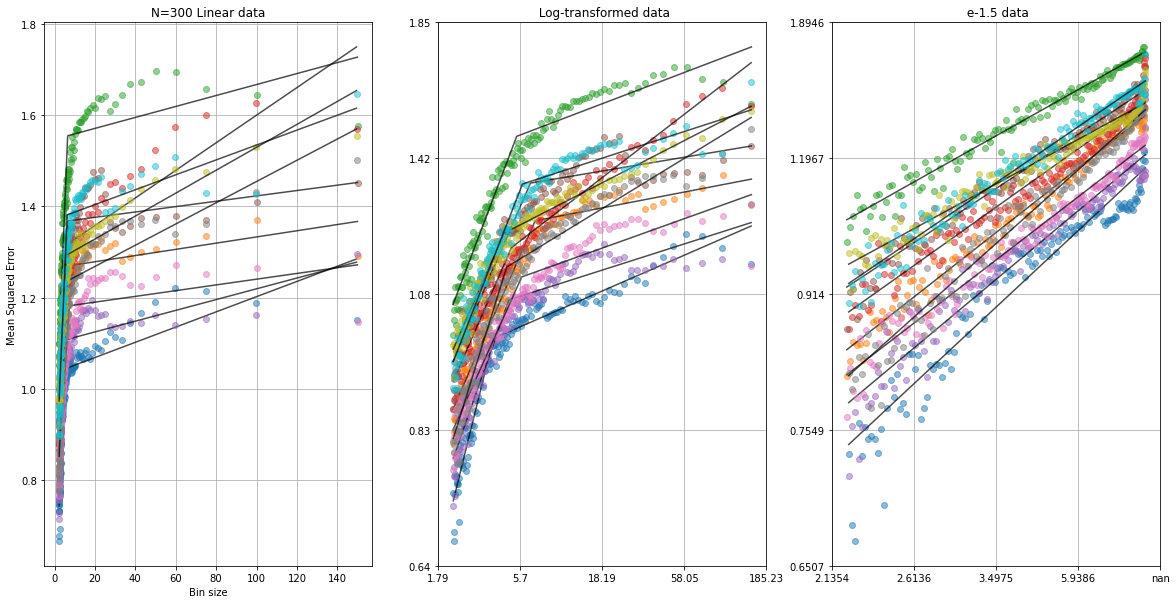

In [42]:

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,10))

for rnum in list(datadict[tnum]):

    ax1.plot(datadict[tnum][rnum]['bin_sizes'], datadict[tnum][rnum]['mse'], 'o', alpha=0.5)
    ax1.plot(datadict[tnum][rnum]['space_lin'], datadict[tnum][rnum]['pwlr'], '-', color='k', alpha=0.7)
    
    ax2.plot(datadict[tnum][rnum]['bin_sizes_log'], datadict[tnum][rnum]['mse_log'], 'o', alpha=0.5)
    ax2.plot(datadict[tnum][rnum]['space_log'], datadict[tnum][rnum]['pwlr_log'], '-', color='k', alpha=0.7)
    
#     ax3.plot(np.flip(datadict[tnum][rnum]['bin_sizes_pwr']), np.flip(datadict[tnum][rnum]['mse_pwr']), 'o', alpha=0.5)
#     ax3.plot(np.flip(datadict[tnum][rnum]['space_pwr']), np.flip(datadict[tnum][rnum]['linfit_pwr']), '-', color='k', alpha=0.7)
    ax3.plot((datadict[tnum][rnum]['bin_sizes_pwr']),(datadict[tnum][rnum]['mse_pwr']), 'o', alpha=0.5)
    ax3.plot((datadict[tnum][rnum]['space_pwr']),(datadict[tnum][rnum]['linfit_pwr']), '-', color='k', alpha=0.7)

xmin, xmax = ax2.get_xlim()
xticks = np.linspace(xmin,xmax,5)
ax2.set_xticks(xticks)
ax2.set_xticklabels(np.exp(xticks).round(2))

ymin, ymax = ax2.get_ylim()
yticks = np.linspace(ymin,ymax,5)
ax2.set_yticks(yticks)
ax2.set_yticklabels(np.exp(yticks).round(2)) 

xmin, xmax = ax3.get_xlim()
ax3.set_xlim([xmax,xmin])
xticks = np.linspace(xmin,xmax,5)
ax3.set_xticks(xticks)
ax3.set_xticklabels(np.power(xticks,(1.0/pwrbase)).round(4))

ymin, ymax = ax3.get_ylim()
ax3.set_ylim([ymax,ymin])
yticks = np.linspace(ymin,ymax,5)
ax3.set_yticks(yticks)
ax3.set_yticklabels(np.power(yticks,(1.0/pwrbase)).round(4))

ax1.set_xlabel('Bin size')
ax1.set_ylabel('Mean Squared Error')
    
ax1.set_title('N=' + str(len(dist)) + ' Linear data')
ax2.set_title(' Log-transformed data')
ax3.set_title(' e-1.5 data')
ax1.grid(b=None, which='both', axis='both')
ax2.grid(b=None, which='both', axis='both')
ax3.grid(b=None, which='both', axis='both')
plt.show()

#

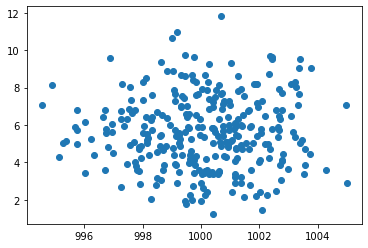

In [39]:
# # RANDOM TEST # #

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

dms_range = get_truncated_normal(mean=5.5, sd=2.0, low=1.0, upp=70.0)
rand_dms = dms_range.rvs(value)

#        spatial_res = np.ndarray(value,dtype=float)
#        spatial_res[:] = 1000
dist_range = get_truncated_normal(mean=1000.0, sd=2.0, low=200.0, upp=3000.0)
rand_dist = dist_range.rvs(value)

data = pd.DataFrame(np.array([rand_dms,rand_dist]).T, columns = ['DMSsw','distance'])
#        data = pd.DataFrame(np.array([rand_dms,spatial_res]).T, columns = ['DMSsw','distance'])
plt.scatter(data.distance,data.DMSsw)

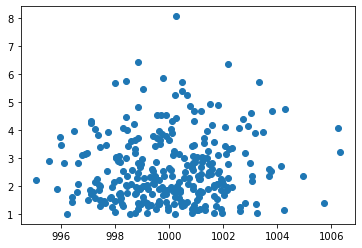

In [40]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

dms_range = get_truncated_normal(mean=1.0, sd=2.0, low=1.0, upp=70.0)
rand_dms = dms_range.rvs(value)

#        spatial_res = np.ndarray(value,dtype=float)
#        spatial_res[:] = 1000
dist_range = get_truncated_normal(mean=1000.0, sd=2.0, low=200.0, upp=3000.0)
rand_dist = dist_range.rvs(value)

data = pd.DataFrame(np.array([rand_dms,rand_dist]).T, columns = ['DMSsw','distance'])
#        data = pd.DataFrame(np.array([rand_dms,spatial_res]).T, columns = ['DMSsw','distance'])
plt.scatter(data.distance,data.DMSsw)

In [36]:
data

,DMSsw,distance
0,4.891538,997.470830
1,7.225985,1000.725557
2,4.499290,1000.015076
3,6.103107,1000.876611
4,2.366125,999.693955
...,...,...
295,5.556950,996.365119
296,3.835953,997.767264
297,4.872188,997.725264
298,8.016637,999.885271


In [104]:
means = np.arange(10)
#%%
#values = [10,50,100,300,3000]                                                  # # number of data points (tnum)
values = [500]                                                                  # # number of data points (tnum)
vlslog_list = []
r2log_list = []
tlog_list = []
plog_list = []

datadict = c.OrderedDict()

for value in values:
#    plt.figure()
#    fig = plt.figure()
    tnum = 't_'+str(value)
    datadict[tnum] = {}
    for j in range(5):                                                        # # number of loop repeats (rnum)
        rnum = 'r_'+str(j)
        datadict[tnum][rnum] = {}
# # # ------------------------------------------------------------------------------------------------------------
        # # RANDOM TEST # #
        
        def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
            return truncnorm(
                (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
        
        dms_range = get_truncated_normal(mean=means[i], sd=2.0, low=1.0, upp=70.0)
#         dms_range = get_truncated_normal(mean=3.0, sd=2.0, low=1.0, upp=70.0)
#         dms_range = get_truncated_normal(mean=3.0, sd=0.1, low=2.9, upp=3.1)

#         rand_dms = dms_range.rvs(value)
        rand_dms =  np.random.rand(value)*5.0

#         dist_range = get_truncated_normal(mean=1000.0, sd=2.0, low=200.0, upp=3000.0)
#         rand_dist = dist_range.rvs(value)
        rand_dist = np.zeros(value)+1000.0
        
        data = pd.DataFrame(np.array([rand_dms,rand_dist]).T, columns = ['DMSsw','distance'])
#        data = pd.DataFrame(np.array([rand_dms,spatial_res]).T, columns = ['DMSsw','distance'])
                
# # # ------------------------------------------------------------------------------------------------------------
        # # SET INPUT PARAMETERS & NO. OF BINS # #
        
        DMS = data['DMSsw'].to_numpy()                                                  # # select DMS data column
        dist = (data['distance']/1000.0).to_numpy()                                     # # convert distance between measurements to km
        kmCov = np.cumsum(dist)                                                         # # cumulative transect distance
        maxlen = int(np.max(kmCov))                                                     # # max transect length as an integer
        maxbins = int(maxlen/2.2)                                                         # # required for later calcs. MSE=0 where bin number > (transect length)/2
#        halflen = int(maxlen/2)                                                         # # required for later calcs. MSE=0 where bin number > (transect length)/2
#        interpint = np.arange(1,halflen+2,1,dtype=np.int)                               # # set range & intervals as: 1km to halflen +2, stepping every 1km. (+1 to create 1 extra bin (because losing bin_0) and +1 to include the max value as the end point = +2)
        interpint = np.arange(1,maxbins+1,1,dtype=np.int)                               # # set range & intervals as: 1km to halflen +2, stepping every 1km. (+1 to create 1 extra bin (because losing bin_0) and +1 to include the max value as the end point = +2)

# # # ------------------------------------------------------------------------------------------------------------
        # # BIN, INTERPOLATE & MSE # # 
        
        processed = c.OrderedDict()
        processed['bin_sizes'] = float(maxlen)/interpint 
                                       # # no.of values to be averaged into bin
        for i in np.arange(len(interpint))+1:                                           # # for each bin size ( 1 : max km (rounded), every 1 ) (Can't start at bin_0 as 'bins' should be a positive integer, i.e. from bin_1 onward)
#            print i
            bin_number = 'bin_'+str(i)                                                  # # set bin_number as bin_ + i
            bin_dms = []                                                                # # empty temporary array
            bin_dist = []                                                               # # empty temporary array
            tempbin = np.array(pd.cut(data.index, i,labels=range(i)))                   # # temporary array for bin steps based on i in data.index
            for i in np.unique(tempbin):                                                # # for i in bin column values i.e. in bin_44, i = 0-43. Set to unique, to remove repetition of values which fill transect length (0,0,0,1,1,1,2,2,2,3,3,3,4,4,4...43,43,43 etc.)
                bin_dms.append(np.nanmean(DMS[np.where(tempbin == i)].astype('float')))       # # append average DMS values for bin
                bin_dist.append(np.nanmean(kmCov[np.where(tempbin == i)].astype('float')))    # # append average distances for bin
            processed[bin_number] = {}
            processed[bin_number]['dms_mean'] = bin_dms                                 # # bin average DMS
            processed[bin_number]['avdist'] = bin_dist                                  # # bin average distance
        
        print("Transect length:", maxlen, "km")
        print("No. interpolation intervals (BINS):", len(interpint))
        
        MSE = []
        
        for i in np.arange(len(interpint)-1)+2:                                         # # loop through bins 2-end inclusive. Start at bin_2, as can't interpolate the single value in bin_1
            # # INTERPOLATION # #
            x = np.array(processed['bin_'+str(i)]['avdist'])
            y = np.array(processed['bin_'+str(i)]['dms_mean'])                          # # DMS values averaged into bins
            interp_rows = np.where((kmCov > np.nanmin(x)) & (kmCov < np.nanmax(x)))[0]
            f = interp.interp1d(x,y)                                                    # # new function interpolate x & y
            DISTinterp = kmCov[interp_rows]
            DMSinterp = f(DISTinterp)                                                   # # use interpolation function returned by 'interp1d'
            # # MEAN SQUARED ERROR # #
            mse = np.nanmean((DMS[interp_rows] - DMSinterp)**2)                                      # # (dms original - dms intp) squared, then averaged to get one value per bin.
            MSE.append(mse)                                                             # # append to list for all bins
#            print 'Bin_',str(i), 'MSE', mse

#        plt.figure()
#        plt.scatter(kmCov,DMS, color = 'g', label = 'Observed', alpha = 0.5)
#        plt.scatter(DISTinterp,DMSinterp, label = bin_number + 'Interpolated', alpha = 0.5)
#        plt.xlabel('Distance (km)')
#        plt.ylabel('DMS (nM)')
#        plt.grid(b=None, which='major', axis='both')
#        plt.legend()
#        plt.show(block=False)
        
# # # ------------------------------------------------------------------------------------------------------------
        # # PIECEWISE LINEAR REGRESSION - LINEAR # #
        
        d = processed['bin_sizes'][1:]                                                  # # bin_sizes (minus the last value, as bin_1 not included)
        e = np.array(MSE[:])                                                                         # # mse values for bin_2 to bin_max
        space_lin = np.linspace(d.min(), d.max(), 1000)                                 # # new temp variable for an arbritrary 1000 points, linearly spaced between bin SIZES bin_2 and bin_max         
        my_pwlf = pwlf.PiecewiseLinFit(d, e)                                            # # use pwlf function PiecewiseLinFit
        
        # # FOR TRUNCATED VLS # #
        #u = d[0:507]                                           # # 197 for 20 km, 297 for 30 km, 397 for 40 km, 497 for 50 km, 997 for 100 km (507 for 51km)
        #v = e[0:507]
        #space_lin = np.linspace(u.min(), u.max(), 1000)                                # # for trunctated VLS
        #my_pwlf = pwlf.PiecewiseLinFit(u, v)                                           # # use pwlf function PiecewiseLinFit
        
        vls = my_pwlf.fit(2)                                                            # # find fit with prescribed no. of segments (x) (no. segments = no. inflections +1)
        pwlr = my_pwlf.predict(space_lin)                                               # # predicted PWLR
        
        print('linear VLS = ', vls[1])
        
        # # Get the slopes
        slopes = my_pwlf.calc_slopes()                                                  # # slope gradients of the two segmented linear regressions
        # # Get my model parameters
        Beta = my_pwlf.beta                                                             # # 3 beta values for the regressions
        # # Calculate the standard errors associated with each beta parameter
        se = my_pwlf.standard_errors()                                                  # # standard error for each beta parameter
        # # Calculate the R^2 value
        rsq = my_pwlf.r_squared()                                                       # # r squared value for the full regression
        
        # calculate the piecewise R^2 value
        R2values = np.zeros(my_pwlf.n_segments)
        for i in range(my_pwlf.n_segments):
            # segregate the data based on break point locations
            xmin = my_pwlf.fit_breaks[i]
            xmax = my_pwlf.fit_breaks[i+1]
            xtemp = my_pwlf.x_data
            ytemp = my_pwlf.y_data
            indtemp = np.where(xtemp >= xmin)
            xtemp = my_pwlf.x_data[indtemp]
            ytemp = my_pwlf.y_data[indtemp]
            indtemp = np.where(xtemp <= xmax)
            xtemp = xtemp[indtemp]
            ytemp = ytemp[indtemp]
        
            # predict for the new data
            yhattemp = my_pwlf.predict(xtemp)
        
            # calculate ssr
            E = yhattemp - ytemp                                                        # # residual vector
            ssr = np.dot(E, E)                                                          # # sum-of-squares of the residuals
        
            # calculate sst
            ybar = np.ones(ytemp.size) * np.mean(ytemp)                                 # # ybar = mean of vector y
            ydiff = ytemp - ybar
            sst = np.dot(ydiff, ydiff)                                                  # # total sum-of-squares
        
            R2values[i] = 1.0 - (ssr/sst)                                               # # coefficient of determination (R2)
        
        print('Segment R-squared values = ', R2values)
        
        datadict[tnum][rnum]['bin_sizes'] = d
        datadict[tnum][rnum]['mse'] = e
        datadict[tnum][rnum]['space_lin'] = space_lin
        datadict[tnum][rnum]['pwlr'] = pwlr
        datadict[tnum][rnum]['vls'] = vls

# # # ------------------------------------------------------------------------------------------------------------
        # # Find y (MSE) intercept at inflection point in PWLR - LINEAR # #
        
#        def find_nearest(array, value):
#            array = np.asarray(array)
#            idx = (np.abs(array - value)).argmin()
#            return array[idx]
#        
#        # # For 1st of ... inflections
#        inflec1 = find_nearest(space_lin, vls[1])
#        inflec1_index = list(space_lin).index(inflec1)
#        mse_intcpt1 = pwlr[inflec1_index]
#        print mse_intcpt1
#        
#        # # For 2nd of ... inflections
#        if len(vls) > 3:
#            inflec2 = find_nearest(space_lin, vls[2])
#            inflec2_index = list(space_lin).index(inflec2)
#            mse_intcpt2 = pwlr[inflec2_index]
#            print mse_intcpt2
#        else:
#            print 'Only 1 inflection'
        
# # # ------------------------------------------------------------------------------------------------------------
        # # Test significance of difference between the slopes (t-test & p-value) - LINEAR # #
        
#        # # For ONE inflection # #
#        if len(vls) <= 3:
#            a = pwlr[0:inflec1_index]
#            b = pwlr[inflec1_index:]
#            
#            t, p = ttest_ind(a, b, equal_var=False)
#            print 'One Inflection'
#            print("ttest_ind:            t = %g  p = %g" % (t, p))
#            if p < 0.05:
#                print 'SIGNIFICANT'
#            else:
#                print 'NOT SIGNIFICANT'
        
            # # VLS LINEAR SPACING # #
            
        d1 = np.log(d)
        e1 = np.log(e)
        
        z1 = np.polyfit(d1, e1, 4)
        fp1 = np.poly1d(z1)
        
        xnew1 = np.linspace(d1.min(), d1.max(), 1000)
        ynew1 = fp1(xnew1)

        my_pwlf1 = pwlf.PiecewiseLinFit(d1, e1)
        vls1 = my_pwlf1.fit(2)                                                          
        pwlr1 = my_pwlf1.predict(xnew1)                                            
        vls_inv = np.exp(vls1)
        
        #---------------------------------------------

        coefs = poly.polyfit(d1, e1, 4)
        ffit = poly.polyval(xnew1, coefs)
        
        #---------------------------------------------
        
        pwrbase = -1.5
        
        d2 = np.power(d,pwrbase)
        e2 = np.power(e,pwrbase)

        z2 = np.polyfit(d2, e2, 1)
        fp2 = np.poly1d(z2)
        
        xnew2 = np.linspace(d2.min(), d2.max(), 1000)
        ynew2 = fp2(xnew2)

        my_pwlf2 = pwlf.PiecewiseLinFit(d2, e2)
        vls2 = my_pwlf2.fit(2)                                                          
        pwlr2 = my_pwlf2.predict(xnew2)                                            
        vls_pinv = np.power(vls2,(1.0/pwrbase))
        
        datadict[tnum][rnum]['bin_sizes_log'] = d1
        datadict[tnum][rnum]['mse_log'] = e1
        datadict[tnum][rnum]['space_log'] = xnew1
        datadict[tnum][rnum]['pwlr_log'] = pwlr1
        datadict[tnum][rnum]['vls_log'] = vls1
        datadict[tnum][rnum]['vls_inv'] = vls_inv

        datadict[tnum][rnum]['bin_sizes_pwr'] = d2
        datadict[tnum][rnum]['mse_pwr'] = e2
        datadict[tnum][rnum]['space_pwr'] = xnew2
        datadict[tnum][rnum]['linfit_pwr'] = ynew2
        datadict[tnum][rnum]['pwlr_pwr'] = pwlr2
        datadict[tnum][rnum]['vls_pwr'] = vls2
        datadict[tnum][rnum]['vls_pinv'] = vls_pinv
        



Transect length: 500 km
No. interpolation intervals (BINS): 227
linear VLS =  6.055013309148019
Segment R-squared values =  [0.90334395 0.29071837]
Transect length: 500 km
No. interpolation intervals (BINS): 227
linear VLS =  5.990537013942021
Segment R-squared values =  [0.89811132 0.3196553 ]
Transect length: 500 km
No. interpolation intervals (BINS): 227
linear VLS =  8.02192301794956
Segment R-squared values =  [0.89324798 0.53602776]
Transect length: 500 km
No. interpolation intervals (BINS): 227
linear VLS =  6.134087164105304
Segment R-squared values =  [0.9066692  0.33035106]
Transect length: 500 km
No. interpolation intervals (BINS): 227
linear VLS =  6.28165438968672
Segment R-squared values =  [0.89500939 0.34896785]


<ipython-input-91-f764fcd83f4e>:32: RuntimeWarning: invalid value encountered in power
  ax3.set_xticklabels(np.power(xticks,(1.0/pwrbase)).round(4))


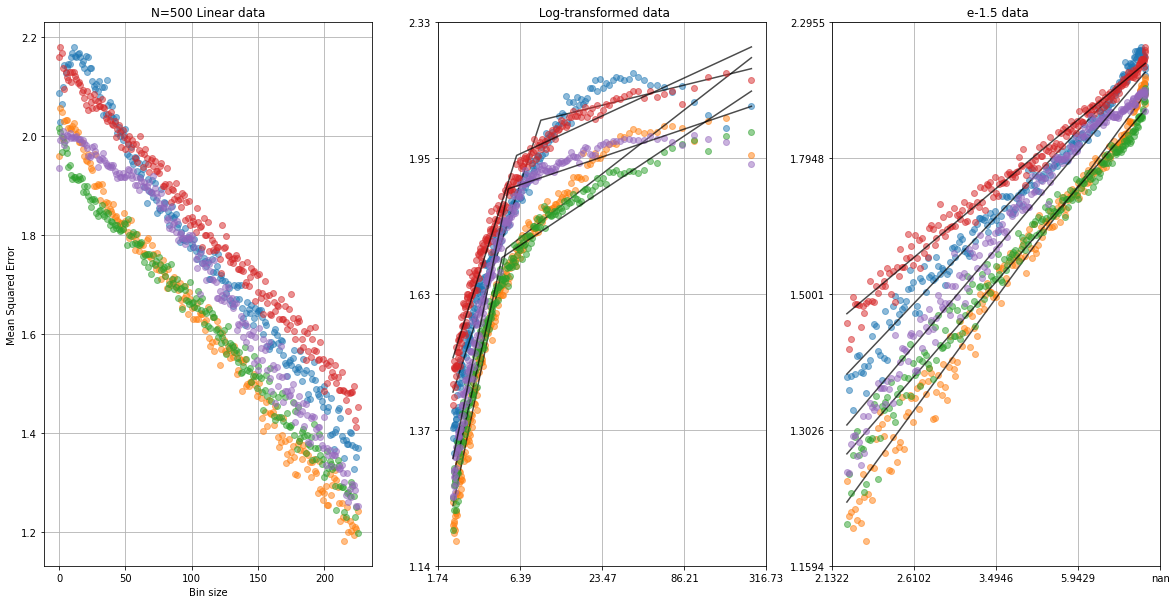

In [91]:

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,10))

for rnum in list(datadict[tnum]):

    ax1.plot(datadict[tnum][rnum]['mse'], 'o', alpha=0.5)
#     ax1.plot(datadict[tnum][rnum]['space_lin'], datadict[tnum][rnum]['pwlr'], '-', color='k', alpha=0.7)
#     ax1.plot(datadict[tnum][rnum]['bin_sizes'], datadict[tnum][rnum]['mse'], 'o', alpha=0.5)
#     ax1.plot(datadict[tnum][rnum]['space_lin'], datadict[tnum][rnum]['pwlr'], '-', color='k', alpha=0.7)
    
    ax2.plot(datadict[tnum][rnum]['bin_sizes_log'], datadict[tnum][rnum]['mse_log'], 'o', alpha=0.5)
    ax2.plot(datadict[tnum][rnum]['space_log'], datadict[tnum][rnum]['pwlr_log'], '-', color='k', alpha=0.7)
    
#     ax3.plot(np.flip(datadict[tnum][rnum]['bin_sizes_pwr']), np.flip(datadict[tnum][rnum]['mse_pwr']), 'o', alpha=0.5)
#     ax3.plot(np.flip(datadict[tnum][rnum]['space_pwr']), np.flip(datadict[tnum][rnum]['linfit_pwr']), '-', color='k', alpha=0.7)
    ax3.plot((datadict[tnum][rnum]['bin_sizes_pwr']),(datadict[tnum][rnum]['mse_pwr']), 'o', alpha=0.5)
    ax3.plot((datadict[tnum][rnum]['space_pwr']),(datadict[tnum][rnum]['linfit_pwr']), '-', color='k', alpha=0.7)

xmin, xmax = ax2.get_xlim()
xticks = np.linspace(xmin,xmax,5)
ax2.set_xticks(xticks)
ax2.set_xticklabels(np.exp(xticks).round(2))

ymin, ymax = ax2.get_ylim()
yticks = np.linspace(ymin,ymax,5)
ax2.set_yticks(yticks)
ax2.set_yticklabels(np.exp(yticks).round(2)) 

xmin, xmax = ax3.get_xlim()
ax3.set_xlim([xmax,xmin])
xticks = np.linspace(xmin,xmax,5)
ax3.set_xticks(xticks)
ax3.set_xticklabels(np.power(xticks,(1.0/pwrbase)).round(4))

ymin, ymax = ax3.get_ylim()
ax3.set_ylim([ymax,ymin])
yticks = np.linspace(ymin,ymax,5)
ax3.set_yticks(yticks)
ax3.set_yticklabels(np.power(yticks,(1.0/pwrbase)).round(4))

ax1.set_xlabel('Bin size')
ax1.set_ylabel('Mean Squared Error')
    
ax1.set_title('N=' + str(len(dist)) + ' Linear data')
ax2.set_title(' Log-transformed data')
ax3.set_title(' e-1.5 data')
ax1.grid(b=None, which='both', axis='both')
ax2.grid(b=None, which='both', axis='both')
ax3.grid(b=None, which='both', axis='both')
plt.show()

#

(300,)

In [73]:
dms_range = get_truncated_normal(mean=3.0, sd=0.1, low=2.9, upp=3.1)

rand_dms = dms_range.rvs(value)

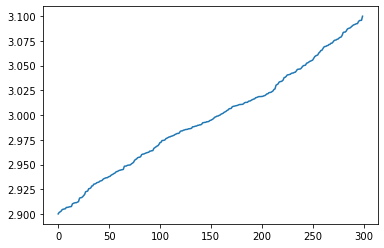

In [74]:
plt.plot(np.sort(rand_dms))

In [75]:
dms_range

array([0.103019  , 0.41752121, 0.5243869 , 0.96561419, 0.45369965,
       0.61454229, 0.19740119, 0.0426281 , 0.48209174, 0.57271983,
       0.11189352, 0.83238955, 0.36834019, 0.03991998, 0.71297586,
       0.01338882, 0.51683374, 0.35550077, 0.78408838, 0.53754268])

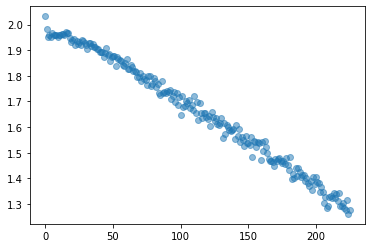

In [105]:
plt.plot(datadict[tnum][rnum]['mse'], 'o', alpha=0.5)

# George - Tom, look at this bit

Text(0, 0.5, 'bin size')

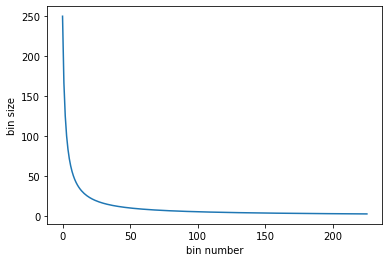

In [106]:
plt.plot(datadict[tnum][rnum]['bin_sizes'])
plt.xlabel('bin number')
plt.ylabel('bin size')

Text(0, 0.5, 'MSE')

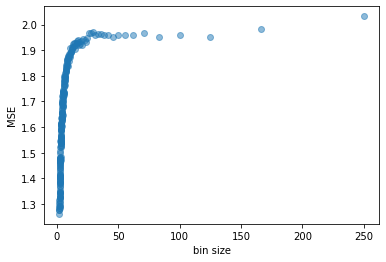

In [107]:
plt.plot(datadict[tnum][rnum]['bin_sizes'], datadict[tnum][rnum]['mse'], 'o', alpha=0.5)
plt.xlabel('bin size')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

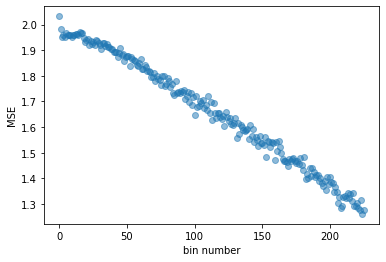

In [108]:
plt.plot(datadict[tnum][rnum]['mse'], 'o', alpha=0.5)
plt.xlabel('bin number')
plt.ylabel('MSE')

# END George - Tom, look at this bit